# 28b-script27_proximity_test

This notebook evaluates the differences between the __already existing proximity analysis__ (_hexproximity_ tables in database) and the result __using Script 27__ (With clipped OSMnx network).

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [29]:
speed_name = '4_5'
res = 10
area_analysis = 'hex'
id_col = 'hex_id'
grl_dir = '../../../data/external/santiago/already_run_outputs/original_osmnx_network_test/'

## Load data

### Load data - Area of interest

In [3]:
# Area of interest (aoi)
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
city = 'alamedabuffer_4500m'

query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

### Load data - Proximity data

Database gdf (db_gdf) - Previously uploaded data (__Multiple Scripts and notebooks__)

<Axes: >

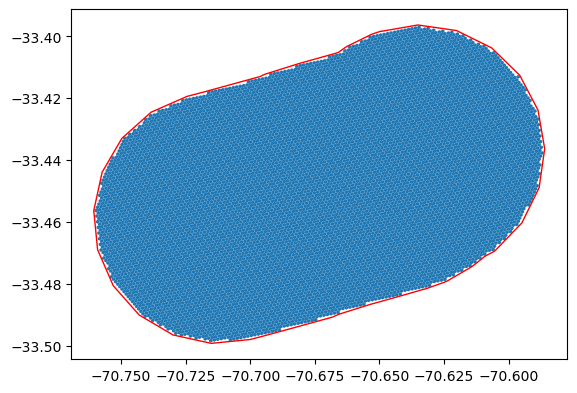

In [22]:
# ----- Load database gdf
if area_analysis == 'hex':
    query = f'SELECT * FROM projects_research.santiago_hexproximity_{speed_name}_kmh WHERE res = {res}'
    db_gdf = aup.gdf_from_query(query)
elif area_analysis == 'unidadesvecinales':
    db_gdf = aup.gdf_from_db(f'santiago_unidadesvecinalesproximity_{speed_name}_kmh','projects_research')
elif area_analysis == 'zonascensales':
    db_gdf = aup.gdf_from_db(f'santiago_zonascensalesproximity_{speed_name}_kmh','projects_research')

# ----- Keep only polygons that area mostly (99.9%) inside area of data availability (aoi)
# Original polygon area
db_gdf_proj = db_gdf.to_crs("EPSG:32719")
db_gdf_proj['area_tot'] = db_gdf_proj.area
db_gdf_proj = db_gdf_proj.to_crs("EPSG:4326")
# Clip
db_gdf_proj = gpd.clip(db_gdf_proj, aoi)
# Clipped polygon area
db_gdf_proj = db_gdf_proj.to_crs("EPSG:32719")
db_gdf_proj['area_clipped'] = db_gdf_proj.area
db_gdf = db_gdf_proj.to_crs("EPSG:4326")
# Filter
db_gdf['pct_inside'] = db_gdf['area_clipped'] / db_gdf['area_tot']
db_gdf = db_gdf.loc[db_gdf['pct_inside'] >= 0.999]
db_gdf.drop(columns=['area_tot','area_clipped','pct_inside'],inplace=True)

# ----- Format differences
# Rename paradas_tp_ruta columns
db_gdf.rename(columns={'paradas_tp_time':'paradas_tp_ruta_time',
                       'paradas_tp_count_15min':'paradas_tp_ruta_count_15min'},inplace=True)

# Show
fig,ax = plt.subplots(1,1)
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=1,zorder=1)
db_gdf.plot(ax=ax,zorder=0)

Local gdf (local_gdf) (__Script 27__)

<Axes: >

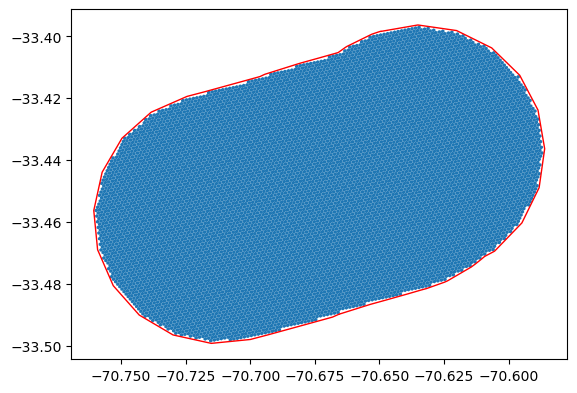

In [23]:
# ----- Load local gdf
if area_analysis == 'hex':
    local_gdf = gpd.read_file(grl_dir + f'santiago_hexproximity_{speed_name}_kmh.gpkg')
elif area_analysis == 'unidadesvecinales':
    local_gdf = gpd.read_file(grl_dir + f'santiago_unidadesvecinalesproximity_{speed_name}_kmh.gpkg')
elif area_analysis == 'zonascensales':
    local_gdf = gpd.read_file(grl_dir + f'santiago_zonascensalesproximity_{speed_name}_kmh.gpkg')

# ----- Keep only polygons that area mostly (99.9%) inside area of data availability (aoi)
# Original polygon area
local_gdf_proj = local_gdf.to_crs("EPSG:32719")
local_gdf_proj['area_tot'] = local_gdf_proj.area
local_gdf_proj = local_gdf_proj.to_crs("EPSG:4326")
# Clip
local_gdf_proj = gpd.clip(local_gdf_proj, aoi)
# Clipped polygon area
local_gdf_proj = local_gdf_proj.to_crs("EPSG:32719")
local_gdf_proj['area_clipped'] = local_gdf_proj.area
local_gdf = local_gdf_proj.to_crs("EPSG:4326")
# Filter
local_gdf['pct_inside'] = local_gdf['area_clipped'] / local_gdf['area_tot']
local_gdf = local_gdf.loc[local_gdf['pct_inside'] >= 0.999]
local_gdf.drop(columns=['area_tot','area_clipped','pct_inside'],inplace=True)

# Show
fig,ax = plt.subplots(1,1)
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=1,zorder=1)
local_gdf.plot(ax=ax,zorder=0)

In [24]:
# Show
print(db_gdf.shape)
db_gdf.head(1)

(9901, 120)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,estaciones_bicicletas_time,estaciones_bicicletas_count_15min,res,city
132395,8ab2c555a4e7fff,"POLYGON ((-70.73412 -33.49281, -70.73403 -33.4...",5.764117,1.25,43.229558,0.0,15.340612,0.25,81.770358,0.0,...,3.865397,7.5,14.098343,1.0,22.313593,0.0,35.103778,0.0,10,Santiago


In [25]:
# Show
print(local_gdf.shape)
local_gdf.head(1)

(9901, 106)


,hex_id,carniceria_time,carniceria_count_15min,hogar_time,hogar_count_15min,bakeries_time,bakeries_count_15min,supermercado_time,supermercado_count_15min,banco_time,...,paradas_tp_metro_count_15min,paradas_tp_tren_time,paradas_tp_tren_count_15min,ciclovias_time,ciclovias_count_15min,estaciones_bicicletas_time,estaciones_bicicletas_count_15min,res,city,geometry
5759,8ab2c555b517fff,24.158547,0.0,42.699947,0.0,17.398453,0.0,21.90524,0.0,34.70328,...,0.0,76.131147,0.0,2.466627,1.0,56.3618,0.0,10,Santiago,"POLYGON ((-70.71464 -33.49796, -70.71455 -33.4..."


## Compare data

In [26]:
merge_data_lst = ['hex_id',
                  'carniceria_time','carniceria_count_15min',
                  'hogar_time','hogar_count_15min',
                  'bakeries_time','bakeries_count_15min',
                  'supermercado_time','supermercado_count_15min',
                  'banco_time','banco_count_15min',
                  'ferias_time','ferias_count_15min',
                  'local_mini_market_time','local_mini_market_count_15min',
                  'correos_time','correos_count_15min',
                  'centro_recyc_time','centro_recyc_count_15min',
                  'hospital_priv_time','hospital_priv_count_15min',
                  'hospital_pub_time','hospital_pub_count_15min',
                  'clinica_priv_time','clinica_priv_count_15min',
                  'clinica_pub_time','clinica_pub_count_15min',
                  'farmacia_time','farmacia_count_15min',
                  'vacunatorio_priv_time','vacunatorio_priv_count_15min',
                  'vacunatorio_pub_time','vacunatorio_pub_count_15min',
                  'consult_ado_priv_time','consult_ado_priv_count_15min',
                  'consult_ado_pub_time','consult_ado_pub_count_15min',
                  'salud_mental_time','salud_mental_count_15min',
                  'labs_priv_time','labs_priv_count_15min',
                  'residencia_adumayor_time','residencia_adumayor_count_15min',
                  'eq_deportivo_priv_time','eq_deportivo_priv_count_15min',
                  'eq_deportivo_pub_time','eq_deportivo_pub_count_15min',
                  'club_deportivo_time','club_deportivo_count_15min',
                  'civic_office_time','civic_office_count_15min',
                  'tax_collection_time','tax_collection_count_15min',
                  'social_security_time','social_security_count_15min',
                  'police_time','police_count_15min',
                  'bomberos_time','bomberos_count_15min',
                  'museos_priv_time','museos_priv_count_15min',
                  'museos_pub_time','museos_pub_count_15min',
                  'cines_time','cines_count_15min',
                  'sitios_historicos_time','sitios_historicos_count_15min',
                  'restaurantes_bar_cafe_time','restaurantes_bar_cafe_count_15min',
                  'librerias_time','librerias_count_15min',
                  'ep_plaza_small_time','ep_plaza_small_count_15min',
                  'ep_plaza_big_time','ep_plaza_big_count_15min',
                  'edu_basica_pub_time','edu_basica_pub_count_15min',
                  'edu_media_pub_time','edu_media_pub_count_15min',
                  'jardin_inf_pub_time','jardin_inf_pub_count_15min',
                  'universidad_time','universidad_count_15min',
                  'edu_tecnica_time','edu_tecnica_count_15min',
                  'edu_adultos_pub_time','edu_adultos_pub_count_15min',
                  'edu_especial_pub_time','edu_especial_pub_count_15min',
                  'bibliotecas_time','bibliotecas_count_15min',
                  'centro_edu_amb_time','centro_edu_amb_count_15min',
                  'paradas_tp_ruta_time','paradas_tp_ruta_count_15min',
                  'paradas_tp_metro_time','paradas_tp_metro_count_15min',
                  'paradas_tp_tren_time','paradas_tp_tren_count_15min',
                  'ciclovias_time','ciclovias_count_15min',
                  'estaciones_bicicletas_time','estaciones_bicicletas_count_15min']

In [30]:
both_gdfs = pd.merge(db_gdf,local_gdf[merge_data_lst],on=id_col)

# Show
print(both_gdfs.shape)
both_gdfs.head(1)

(9901, 222)


,hex_id,geometry,supermercado_time_x,supermercado_count_15min_x,clinica_priv_time_x,clinica_priv_count_15min_x,clinica_pub_time_x,clinica_pub_count_15min_x,hospital_priv_time_x,hospital_priv_count_15min_x,...,paradas_tp_ruta_time_y,paradas_tp_ruta_count_15min_y,paradas_tp_metro_time_y,paradas_tp_metro_count_15min_y,paradas_tp_tren_time_y,paradas_tp_tren_count_15min_y,ciclovias_time_y,ciclovias_count_15min_y,estaciones_bicicletas_time_y,estaciones_bicicletas_count_15min_y
0,8ab2c555a4e7fff,"POLYGON ((-70.73412 -33.49281, -70.73403 -33.4...",5.764117,1.25,43.229558,0.0,15.340612,0.25,81.770358,0.0,...,1.726117,21.25,29.57213,0.0,81.443477,0.0,15.517823,0.0,61.67413,0.0


In [31]:
attributes_list = merge_data_lst.copy()
attributes_list.remove(id_col)

# Compare old and new amenities
compare_list = []
for attribute in attributes_list:

    old_attribute = f"{attribute}_x"
    new_attribute = f"{attribute}_y"
    both_gdfs[f"{attribute}_diff"] = abs(both_gdfs[new_attribute] - both_gdfs[old_attribute])

    compare_list.append(f"{attribute}_diff")

# Visualize sum of attribute value differences (sum of each _diff col values)
summary_df = pd.DataFrame()
i = 0
for compared_attribute in compare_list:

    diff_value = both_gdfs[compared_attribute].sum()
    summary_df.loc[i,'attribute'] = compared_attribute
    summary_df.loc[i,'diff'] = diff_value

    i = i+1

summary_df['rounded_diff'] = round(summary_df['diff'],0)

# Show
summary_df.head(1)

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

,attribute,diff,rounded_diff
0,carniceria_time_diff,17556.189617,17556.0


## Differences (Table)

In [32]:
summary_df.head(51)

,attribute,diff,rounded_diff
0,carniceria_time_diff,17556.189617,17556.0
1,carniceria_count_15min_diff,13255.027878,13255.0
2,hogar_time_diff,20036.645776,20037.0
3,hogar_count_15min_diff,31932.493317,31932.0
4,bakeries_time_diff,2106.840235,2107.0
5,bakeries_count_15min_diff,3224.592818,3225.0
6,supermercado_time_diff,4709.343577,4709.0
7,supermercado_count_15min_diff,1669.642416,1670.0
8,banco_time_diff,25629.063497,25629.0
9,banco_count_15min_diff,52635.058751,52635.0


In [33]:
summary_df.tail(51)

,attribute,diff,rounded_diff
51,tax_collection_count_15min_diff,3.668432,4.0
52,social_security_time_diff,29003.469183,29003.0
53,social_security_count_15min_diff,45.001580,45.0
54,police_time_diff,7867.240170,7867.0
55,police_count_15min_diff,195.765779,196.0
56,bomberos_time_diff,4785.046402,4785.0
57,bomberos_count_15min_diff,78.462227,78.0
58,museos_priv_time_diff,7463.786987,7464.0
59,museos_priv_count_15min_diff,8.196102,8.0
60,museos_pub_time_diff,8977.741637,8978.0


## Differences (visualized)

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


<Axes: >

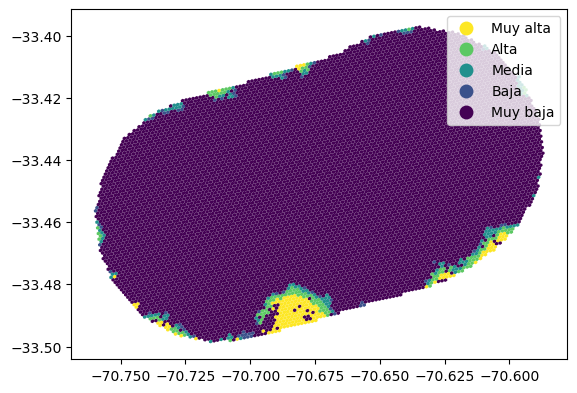

In [34]:
diff_attribute = 'supermercado_time_diff'

both_gdfs['Grado_diff'] = np.nan

# Very high difference (More than 10 minutes)
both_gdfs.loc[both_gdfs[diff_attribute]>=10 , 'Grado_diff'] = 'Muy alta'
# High difference (5 to 10 minutes)
both_gdfs.loc[(both_gdfs[diff_attribute]>=5) & (both_gdfs[diff_attribute]<10), 'Grado_diff'] = 'Alta'
# Medium difference (2 to 5 minutes)
both_gdfs.loc[(both_gdfs[diff_attribute]>=2) & (both_gdfs[diff_attribute]<5), 'Grado_diff'] = 'Media'
# Low difference (1 to 2 minutes)
both_gdfs.loc[(both_gdfs[diff_attribute]>=1) & (both_gdfs[diff_attribute]<2), 'Grado_diff'] = 'Baja'
# Very low difference (less than 1 minute)
both_gdfs.loc[(both_gdfs[diff_attribute]<1), 'Grado_diff'] = 'Muy baja'

categories = ['Muy alta', 'Alta', 'Media', 'Baja', 'Muy baja']
both_gdfs['Grado_diff'] = pd.Categorical(both_gdfs['Grado_diff'], categories=categories, ordered=True)

fig,ax = plt.subplots(1,1)
both_gdfs.plot('Grado_diff','viridis_r', legend=True,ax=ax)

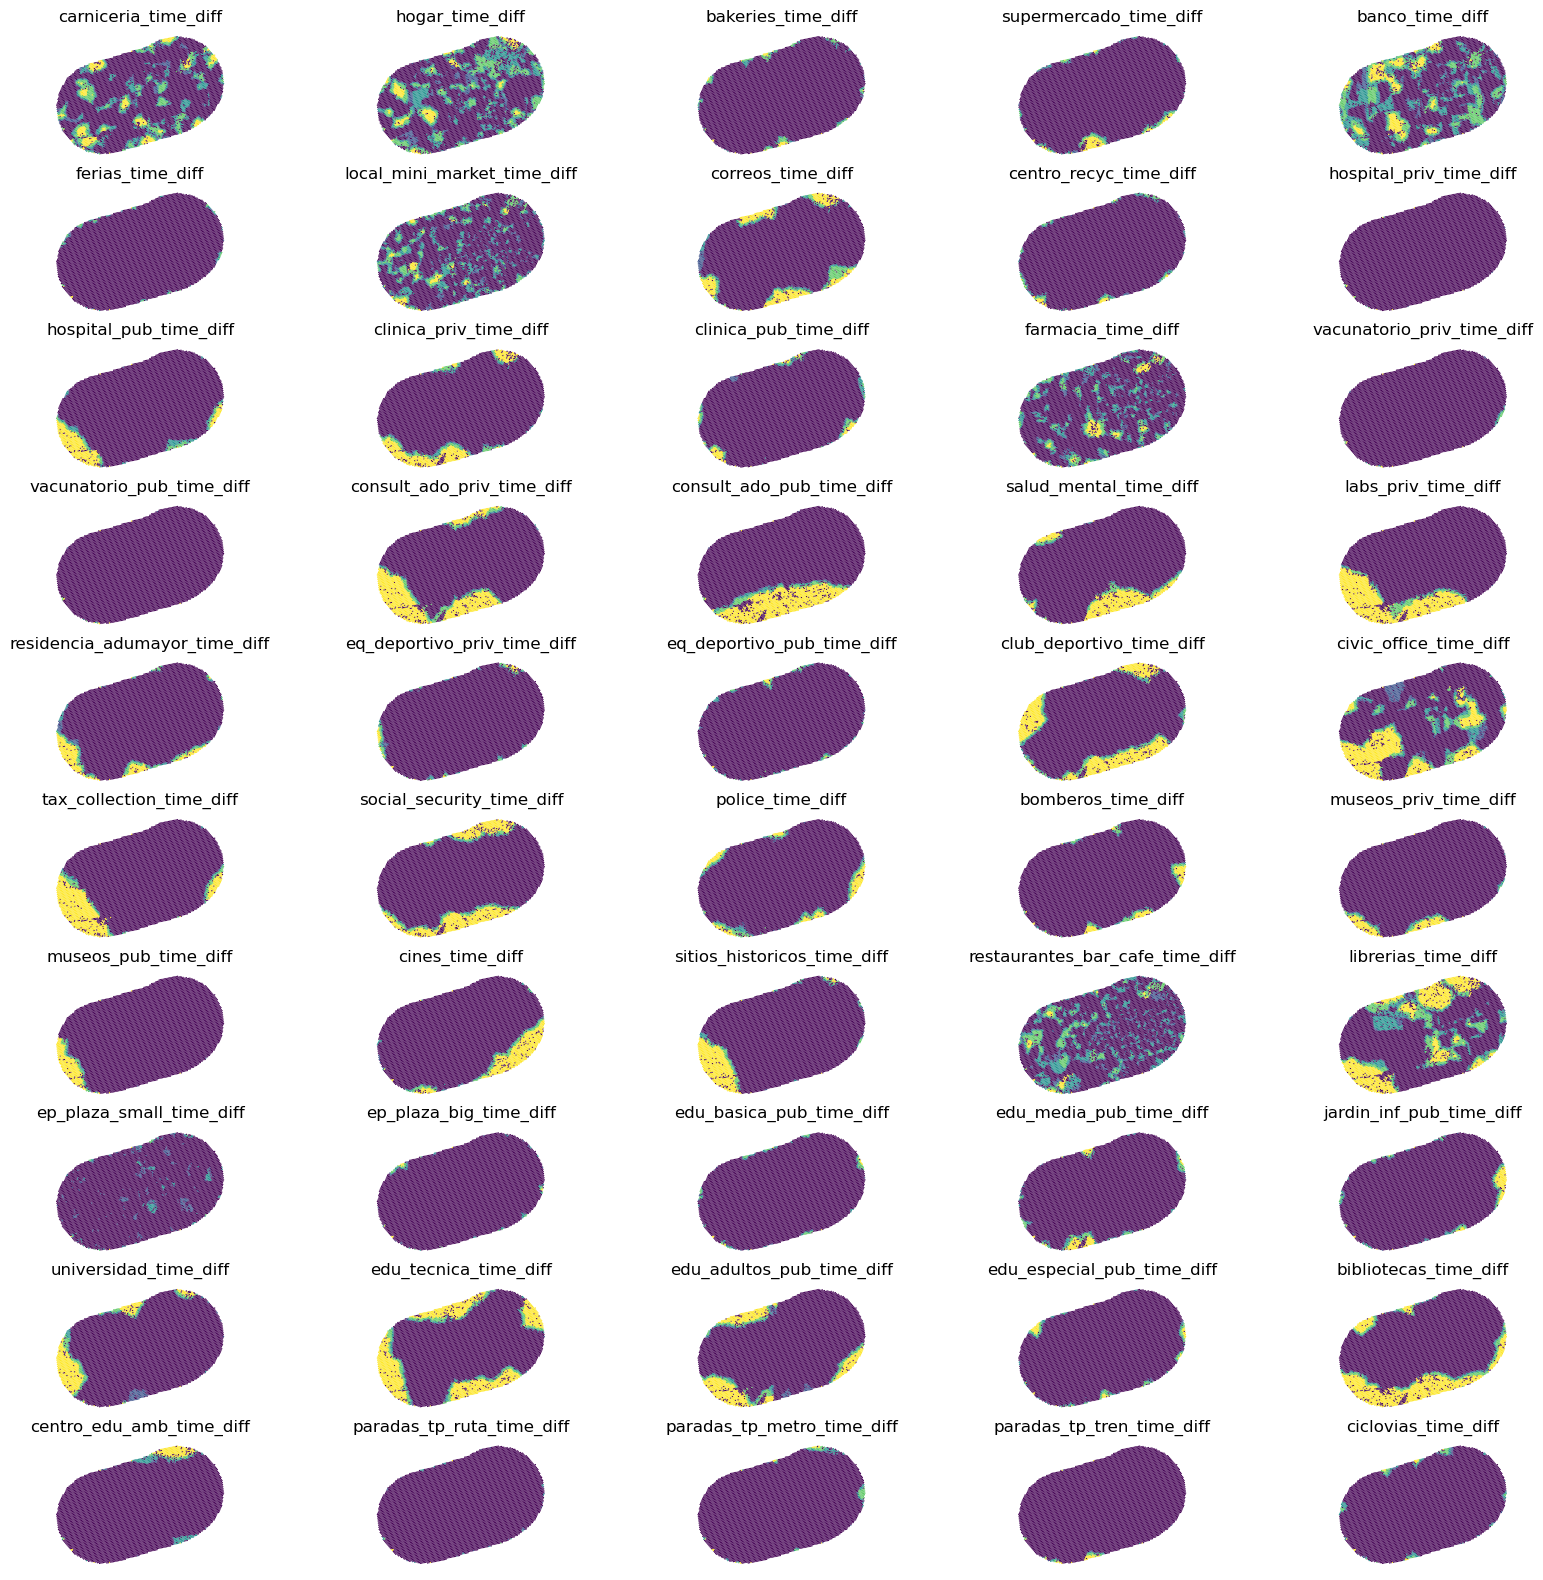

In [35]:
time_diff_cols = []
count_diff_cols = []

for diff_attribute in compare_list:
    if 'time' in diff_attribute:
        time_diff_cols.append(diff_attribute)
    else:
        count_diff_cols.append(diff_attribute)

fig,axs = plt.subplots(10,5,figsize=(20,20))

n = 0
for i in range(10):
    for j in range(5):

        # ----- Current analysed attribute
        diff_attribute = time_diff_cols[n]

        # ----- Categorize time differences
        # Very high difference (More than 10 minutes)
        both_gdfs.loc[both_gdfs[diff_attribute]>=10 , 'Grado_diff'] = 'Muy alta'
        # High difference (5 to 10 minutes)
        both_gdfs.loc[(both_gdfs[diff_attribute]>=5) & (both_gdfs[diff_attribute]<10), 'Grado_diff'] = 'Alta'
        # Medium difference (2 to 5 minutes)
        both_gdfs.loc[(both_gdfs[diff_attribute]>=2) & (both_gdfs[diff_attribute]<5), 'Grado_diff'] = 'Media'
        # Low difference (1 to 2 minutes)
        both_gdfs.loc[(both_gdfs[diff_attribute]>=1) & (both_gdfs[diff_attribute]<2), 'Grado_diff'] = 'Baja'
        # Very low difference (less than 1 minute)
        both_gdfs.loc[(both_gdfs[diff_attribute]<1), 'Grado_diff'] = 'Muy baja'

        # ----- Plot
        both_gdfs.plot('Grado_diff','viridis_r',ax=axs[i,j])
        axs[i, j].set_title(diff_attribute)
        axs[i, j].axis("off")
        n+=1

# Muy alta --> Amarillo
# Alta --> Verde claro
# Media --> Azul claro
# Baja --> Azul oscuro
# Muy baja --> Morado

# Other

### sjoin test

In [4]:
sjoin_test = False

In [5]:
if sjoin_test:
    db_gdf = gpd.read_file('../../../data/external/santiago/areal_data/' + f'unidadesvecinales_areal.gpkg')
    #db_gdf = aup.gdf_from_db(f'santiago_unidadesvecinalesproximity_{speed_name}_kmh','projects_research')
    
    # Show
    print(db_gdf.shape)
    db_gdf.head(1)

In [6]:
if sjoin_test:
    db_cut = gpd.sjoin(db_gdf, aoi[['geometry']])
    db_cut.drop(columns=['index_right'],inplace=True)
    
    # Show
    print(db_cut.shape)
    db_cut.head(1)

In [7]:
if sjoin_test:
    # Show
    fig,ax = plt.subplots(1,1)
    aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=1,zorder=1)
    db_cut.plot(ax=ax,zorder=0)

In [1]:
200/200

1.0

In [20]:
batch_size = 199/201
for k in range(int(batch_size)+1):
    print('a')

a


In [21]:
batch_size = 200/201
for k in range(int(batch_size)+1):
    print('a')

a


In [22]:
batch_size = 201/201
for k in range(int(batch_size)+1):
    print('a')

a
a


In [19]:
if 250%250:
    print('a')

In [35]:
area_analysis = 'hex'
code_column = 'hex_id'

if area_analysis == 'hex':
    # For this script, will only use res=10
    res = 10

    gdf = aup.create_hexgrid(aoi, res)
    gdf.rename(columns={f'hex_id_{res}':'hex_id'}, inplace=True)
    gdf['res'] = res
    gdf = gdf[[code_column,'res','geometry']].copy()  
    
# Set gdf CRS
try:
    gdf = gdf.to_crs("EPSG:4326")
except:
    gdf = gdf.set_crs("EPSG:4326")
    
# Explode area of analysis gdf
gdf = gdf.explode(ignore_index=True)

# 2.2 --------------- GROUP DATA BY AREA OF ANALYSIS
# ------------------- This groups proximity data by area of analysis

if area_analysis == 'hex':

    hex_gdf = gdf.copy()
    poly_proximity = gpd.GeoDataFrame()

    for r in hex_gdf.res.unique():

        # Calculate mean proximity within area of analysis
        hex_tmp = hex_gdf[hex_gdf.res == r].copy()

In [36]:
hex_tmp

,hex_id,res,geometry
0,8ab2c5546567fff,10,"POLYGON ((-70.70292 -33.41824, -70.70355 -33.4..."
1,8ab2c555062ffff,10,"POLYGON ((-70.74512 -33.44674, -70.74575 -33.4..."
2,8ab2c556c757fff,10,"POLYGON ((-70.61019 -33.40368, -70.61082 -33.4..."
3,8ab2c5550b37fff,10,"POLYGON ((-70.73376 -33.43458, -70.73439 -33.4..."
4,8ab2c555a3b7fff,10,"POLYGON ((-70.72375 -33.49264, -70.72438 -33.4..."
...,...,...,...
10116,8ab2c5568c37fff,10,"POLYGON ((-70.61667 -33.41130, -70.61730 -33.4..."
10117,8ab2c554e8dffff,10,"POLYGON ((-70.65451 -33.45497, -70.65514 -33.4..."
10118,8ab2c55590e7fff,10,"POLYGON ((-70.68182 -33.49031, -70.68245 -33.4..."
10119,8ab2c554839ffff,10,"POLYGON ((-70.63449 -33.47308, -70.63512 -33.4..."
